In [ ]:
!pip install ultralytics

In [ ]:
#imports

from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt
from ultralytics.models.fastsam import prompt
import os
import gc
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Frame the Problem

This notebook outlines the process of developing a deep learning model designed to identify different strains of bacteria present in petri dish images. Utilizing advanced techniques such as  deep learning, instance segmentation and masking, the model can analyze an image and accurately detect and clarify the bacterial colonies within the petri dish.

The workflow involves configuring and training a YOLOv8 model, a highly effective tool within machine learning that is often used for its efficiency in object detection and segmentation tasks. The model’s capabilities will be integrated into a web interface, in an effort to provide a cost effective solution for identifying bacterial strains. This innovation aims to support regions and institutions that lack access to expensive medical equipment, thereby enhancing diagnostic capabilities in a resource limited environment.


# The Data
The data used in this model was provided by Dr. Vander Schaaf and her biology team at Olivet Nazarene University. The data included ten strains of bacteria present in human urine. Dr.Vander Schaaf's team cultured multiple samples of each strain, taking pictures at four separate intervals: 18 hours, 24 hours, 48 hours, and 72 hours. The ten strains of bacteria:




* Candida Albicans
* Enterococcus Faecalis
* Escherichia coli
* Klebsiella Pneumoniae
* Proteus Mirabilis
* Pseudomonas Aeruginosa
* Staphylococcus Aureus
* Staphylococcus Epidermidis
* Staphylococcus Saprophyticus
* Streptococcus Agalactiae


The total amount of the data was 4,121 images.


In [ ]:
#Function created to get the file path
def getFiles():
  dp = "/content/drive/MyDrive/Filtered_Bacteria/filter_Bacteria/TheOneThatDoesntWork"
  filenames = os.listdir(dp)
  return filenames, dp

The command below recursively searches the file for and removes all dicectories named .ipynb_checkpoints within the current folder.

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

# Preparing the data
The initial steps involved organizing the data provided by Dr. Vander Schaaf's biology team. During our analysis, there was a question of whether the fastSAM model would be able to detect certain colonies that appeared too small or translucent. To address this, we created a function to extract masks from each photo. The mask size is set to less than 300 pixels to focus on the individual colonies. If no colonies are detected-whether due to being too small,translucent, or overgrown-the photo is added to a separate file from those with detected masks.

The purpose of this process is to filter and refine our batch of data. Having clear and accurate data will be beneficial when creating our model.

In [ ]:
def getMasks(everything_results,missings,missingLoc,missingCount,filename):


  missingCount += 1
  arr = []
  try:
    # Extracts the masks from the first result in the everything_results list
    masks = everything_results[0].masks
    # Determine the number of masks available
    stop = len(masks)
    # Iterate over each mask
    for i in range(stop):
      check = len(everything_results[0].masks.xyn[i])
      # If the length is less than 300,consider it a valid mask and add it to arr.
      if check < 300:
        arr.append(everything_results[0].masks.xyn[i])

  # If no valid mask were found, update the missing counter and add the filename to missingLoc
    if len(arr) == 0:
      missings += 1
      missingLoc.append(filename)

  except:
    print("No Masks")
    missings += 1
    missingLoc.append(filename)

  return arr,missings,missingLoc,missingCount

After identifying which pieces of data had a mask present, we extracted those masks and converted them into text files. The text file contains all the mask information, organized in a structured way that is easy to parse and review.


The images that did not have any mask detected within the petri dish were removed from the data set. Resulting in a new value of 2,029 images. However that value decreased further to 2,006 after the poor performance of the bacteria strain Proteus Mirabilis which only found masks in 23 photos out of 283. This poor result is largely due to the blurry growth of this particular bacteria along with the negative impact of glare.


In [ ]:

def writeOut(filename,masks,key):
  #replace the last three characters with 'txt'
  oName = filename[:-3]
  oName = oName + "txt"

  #Full file path for saving the output
  filepath = os.path.join("/content/drive/MyDrive/Filtered_Bacteria/filter_Bacteria/TextOutput/ProteusMirabilis", oName)

  try:
    with open(filepath,"x")  as file:

      toWrite = ""
      #Itereate ove each array in masks
      for array in masks:
        toWrite += str(key) + " "
        #Itereate over each array in the current array
        for mask in array:
          #Itereate over each pair in the current mask
          for pair in mask:
            #print(mask)
            toWrite += str(pair) + " "

        toWrite += "\n"

      file.write(toWrite)

    file.close()#Closing file
  except:
    print("An erron was found")

In [ ]:
#Run before each run to clear the ram
gc.collect()


#The FastSAM Model

This code utilizes the Fast Segment Anything Model (FastSAM), which is a real-time CNN-based solution for the Segment Anything task. It is particularly useful for image segmentation tasks. Here the model will employ instance segmentation to detect and segment individual objects within the image. As a result it will provide detailed masks that distinguish between different instances of the same class.





In [ ]:
#Initialize the FastSAM model
model = FastSAM("FastSAM-s.pt")

#Initialize variales to track missing marks and their locations
missings = 0 #Total number of images with no masks
missingLoc = [] #array of locations missing masks
missingCount = 0
maskDict = {} #dictionary to store masks by filename
key = 5 #Key used in write out function
numOfMasks = []
amount = 0
count = 1
filenames,dp = getFiles() #retrieve filenames and directory path

# Iterate through the list
for filename in filenames:
  amount += 1
  # Construct the full path
  full_path = os.path.join(dp, filename)
  source = full_path

  # Run inference on an image
  everything_results = model(source, device="0", retina_masks=True, imgsz=640, conf=0.8, iou=0.3, max_det = 15)

  # Prepare a Prompt Process object
  prompt_process = FastSAMPrompt(source, everything_results, device="0")
  numOfMasks.append(len(everything_results))

  #saving filtered data to a dict
  masks, missings, missingLoc, missingCount = getMasks(everything_results,missings,missingLoc,missingCount,filename)

  #adding the masks to the dicts
  maskDict[filename] = masks
  if len(masks) > 0:
    writeOut(filename,masks,key)
    #Generate annotations for the masks
  ann = prompt_process.everything_prompt()

  #Code to make immages with the masks on top of them
  #prompt_process.plot(annotations=ann, output="/content/Output")

  gc.collect() #perform garbage collection to free up memory

gc.collect()


Due to our team's decision to remove Proteus Mirabilis from the database, we had to relabel each file accordingly.

In [ ]:
#Iterate through each filename in the first directory
for filename1 in filenames1:
  #Convert the filename to a string and remove the file extension
  n1 = str(filename1)
  n1 = n1[:-4]

  for filename2 in filenames2:
      n2 = str(filename2)
      n2 = n2[:-4]
      #If the base filename matches
      if n1 == n2:
        test1 = "/content/drive/MyDrive/filter_Bacteria/Filtered" + bact + "/" + str(filename1)
        test2 = "/content/drive/MyDrive/filter_Bacteria/TextOutput/" + bact + "/" + filename2

        #Copy the matched file from the second directory to the target directory
        shutil.copy(test1, "/content/drive/MyDrive/DataPairs/" + bact)
        #Copy the matched file from the first directory to the target directory
        shutil.copy(test2, "/content/drive/MyDrive/DataPairs/" + bact)

        break


In [ ]:
#Define the directory path containing the files to be relabeled
dp = "/content/drive/MyDrive/DataPairs/ValidationPairs"

#Get the list of specific files
filenames = os.listdir(dp)


In [ ]:
#Based on the number that is passed into the function the number that that strand is to be labeled as is returned
def numFix(num):
  if num == 1:
    return 0
  if num == 2:
    return 1
  if num == 3:
    return 2
  if num == 4:
    return 3
  if num == 6:
    return 4
  if num == 7:
    return 5
  if num == 8:
    return 6
  if num == 9:
    return 7
  if num == 10:
    return 8

In [ ]:
#Iterate through each file in the directory
for filename in filenames:
  sufix = filename[-1]
  if sufix == "t":
    try:
      fp = dp + "/" + filename
      lines = ""#variable to store the contents of the open files
      with open(fp, 'r') as file:#opening each file in the directory

        for line in file:
          #Isolate the first number
          index = line.find(' ')
          first = line[0:index]

          #Map the first number using the numFix function
          newNum = numFix(int(first))

          #Create the new line with the mapped number
          newLine = str(newNum) + line[index:]
          lines += newLine
      #Open the file for writing
      with open(fp, 'w') as file:
        file.write(lines) #overwriteing file contents with the updated content

    except:
      print("An error was found")

In [ ]:
#Define the specfic bacteria name
bact = "StreptococcusAgalactiae"

In [ ]:
#Define the directory path where the second set of filenames is located
dp1 = "/content/drive/MyDrive/filter_Bacteria/" + bact#direcgtory with bactiria immages
dp2 = "/content/drive/MyDrive/filter_Bacteria/TextOutput/" + bact#directory with the mask data files

filenames1 = os.listdir(dp1)
filenames2 = os.listdir(dp2)

#YOLOv8 Model

YOLOv8 is a deep learning model used for object detection and segmentation. It divides the input image into a grid and performs classification and localization with each grid cell. The code provided creates new parameters for Ultralytics settings. It initializes the YOLOv8 model, specifically designed for instance segmentation tasks.
The YOLOv8 model is used for detecting objects and generating masks that depict the boundaries of these objects within an image. In our project, the model is employed to detect colonies in the image and provide a precise mask for each detected colony. Using instance segmentation allows for detailed and accurate analysis of the objects in the image.


In [ ]:
#Open the settings.yaml file in read mode and read the content
with open("/root/.config/Ultralytics/settings.yaml", 'r') as file:
  text = file.read()
  print(text)

#Define the new settings here as a multi-line string
text = """settings_version: 0.0.4
datasets_dir: /content/drive/MyDrive/DataPairs
weights_dir: weights
runs_dir: runs
uuid: 569f3ba64b326db489132663f79cd37279811de477381b83ac131e6cdd129cbb
sync: true
api_key: ''
openai_api_key: ''
clearml: true
comet: true
dvc: true
hub: true
mlflow: true
neptune: true
raytune: true
tensorboard: true
wandb: true"""

#open the settings.yaml file in write mode and write the new settings
with open("/root/.config/Ultralytics/settings.yaml", 'w') as file:
        file.write(text)


In [ ]:
import shutil#Modual improted for the ability to copy files to other directories

# Matching up the textfiles and images

#Reduced Data Model

In [ ]:
import torch#Import for PyTorch

In [ ]:
#Plotting imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
%matplotlib inline

In [ ]:
#Perform garbage collection to free up memory
gc.collect()

In [ ]:
# Check if CUDA is available for gpu access
torch.cuda.is_available()

In [ ]:
from ultralytics import YOLO

In [ ]:
#Load a pretrained YOLOv8 nano model for segmentation tasks using the specified YAML configuration file
model = YOLO("yolov8n-seg.yaml")

In [ ]:
# Train the model
results = model.train(data="G:\My Drive\ModelRuns\ReducedDataModel\ReducedSetKey.yaml", epochs=100, imgsz=640,verbose = True, seed = 42,optimizer = "AdamW",device = 0,patience = 15)

In [ ]:
#validate the model on the validation dataset
res_val = model.val()

In [ ]:
#Output from the validation data run to analize proformance
Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259039 parameters, 0 gradients, 12.0 GFLOPs
val: Scanning G:\My Drive\DataPairs\ValidationPairs.cache... 146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 146/146 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\Carter\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]
                   all        146       1185      0.773      0.726      0.821      0.727      0.773      0.725      0.811      0.379
      Escherichia Coli         65        495      0.696      0.754      0.825      0.733      0.694      0.752      0.817       0.42
 Klebsiella Pneumoniae         24        194      0.774      0.639      0.784      0.707      0.774      0.639       0.77      0.346
Pseudomonas Aeruginosa         13         66      0.786      0.669      0.764      0.659      0.786      0.669      0.764       0.41
Staphylococcus Aureusr         21        212      0.832       0.75      0.835      0.743      0.832       0.75      0.827      0.367
Staphylococcus Saprophyticus         23        218      0.779      0.817      0.895      0.792      0.779      0.817      0.878      0.353
Speed: 0.3ms preprocess, 12.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs\segment\train32

In [ ]:
#export the trained model (default) and in ONNX format to be deployed in a web aplication
model.export()
model.export(format = 'onnx')

In [ ]:
Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

PyTorch: starting from 'runs\segment\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 41, 8400), (1, 32, 160, 160)) (6.5 MB)

TorchScript: starting export with torch 2.3.0...
TorchScript: export success  1.1s, saved as 'runs\segment\train\weights\best.torchscript' (12.9 MB)

Export complete (1.3s)
Results saved to G:\My Drive\ModelRuns\ReducedDataModel\runs\segment\train\weights
Predict:         yolo predict task=segment model=runs\segment\train\weights\best.torchscript imgsz=640
Validate:        yolo val task=segment model=runs\segment\train\weights\best.torchscript imgsz=640 data=G:\My Drive\ModelRuns\ReducedDataModel\ReducedSetKey.yaml
Visualize:       https://netron.app
Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.0 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

PyTorch: starting from 'runs\segment\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 41, 8400), (1, 32, 160, 160)) (6.5 MB)

ONNX: starting export with onnx 1.16.1 opset 17...
ONNX: export success  0.8s, saved as 'runs\segment\train\weights\best.onnx' (12.6 MB)

Export complete (0.8s)
Results saved to G:\My Drive\ModelRuns\ReducedDataModel\runs\segment\train\weights
Predict:         yolo predict task=segment model=runs\segment\train\weights\best.onnx imgsz=640
Validate:        yolo val task=segment model=runs\segment\train\weights\best.onnx imgsz=640 data=G:\My Drive\ModelRuns\ReducedDataModel\ReducedSetKey.yaml
Visualize:       https://netron.app

In [ ]:
# Define the names of the bacterial strains and background for the confusion matrix lables
names = ["Candida Albicans","Enterococcus Faecalis","Escherichia Coli", "Klebsiella Pneumoniae", "Pseudomonas Aeruginosa", "Staphylococcus Aureusr","Staphylococcus Epidermidis", "Staphylococcus Saprophyticus","Streptococcus Agalactiae","Background"]

In [ ]:
# Extract the confusion matrix from the training results
x = results.confusion_matrix.matrix
print(x)

In [ ]:
[[        448          23           0           1           1         380]
 [          0         139           1           0           2         130]
 [          9           6          51           0           0          46]
 [          0           8           4         183           5          92]
 [          0           1           0           3         192         132]
 [         38          17          10          25          18           0]]

In [ ]:
# Transpose the confusion matrix for proper format
x= x.transpose()
x

In [ ]:
array([[        448,           0,           9,           0,           0,          38],
       [         23,         139,           6,           8,           1,          17],
       [          0,           1,          51,           4,           0,          10],
       [          1,           0,           0,         183,           3,          25],
       [          1,           2,           0,           5,         192,          18],
       [        380,         130,          46,          92,         132,           0]])

In [ ]:
# Plot the confusion matrix
sn.heatmap(x, annot=x, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names, yticklabels=names,fmt='g')
sn.set(font_scale=1.4) # for label size
#lables for the graphs
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#rotating the lables on the x-axis  45 degrees
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrix.svg",bbox_inches='tight')
plt.show()

# Add the graph here!

In [ ]:
# Normalize the confusion matrix by the sum of each column
x2 =  x.astype('float') / x.sum(axis=0)[:, np.newaxis]
x2 = np.round(x2, 4)

In [ ]:
# Plot the normalized confusion matrix
sn.heatmap(x2, annot=x2, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names, yticklabels=names,fmt='g')
sn.set(font_scale=1.4) # for label size
#lables for the graphs

plt.title('Confusion Matrix Normalized')
plt.xlabel('Predicted')
plt.ylabel('Actual')
#rotating the lables on the x-axis  45 degrees
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrix.svg",bbox_inches='tight')
plt.show()

In [ ]:
# Train the model
results = model.train(data="9StrandOG.yaml", epochs=150, imgsz=640,verbose = True, seed = 42,optimizer = "auto",device = 0,patience = 20)

New https://pypi.org/project/ultralytics/8.2.45 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.44  Python-3.10.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
engine\trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=9StrandOG.yaml, epochs=150, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

train: Scanning G:\My Drive\Research\Summer 2024\projects\Bacteria\Data\TempProjectStorage\ReLabledData9Classes\TrainingSet... 1776 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1776/1776 [00:15<00:00, 113.50it/s]


train: New cache created: G:\My Drive\Research\Summer 2024\projects\Bacteria\Data\TempProjectStorage\ReLabledData9Classes\TrainingSet.cache


val: Scanning G:\My Drive\Research\Summer 2024\projects\Bacteria\Data\TempProjectStorage\ReLabledData9Classes\TestSet... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:03<00:00, 61.38it/s]


val: New cache created: G:\My Drive\Research\Summer 2024\projects\Bacteria\Data\TempProjectStorage\ReLabledData9Classes\TestSet.cache
Plotting labels to runs\segment\train5\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\segment\train5
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/150      3.19G       6.05      6.033      16.29      4.092        135        640: 100%|██████████| 111/111 [00:27<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.40it/s]

                   all        201       1782          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/150         3G      3.036      2.948      4.985      1.954        143        640: 100%|██████████| 111/111 [00:24<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        201       1782      0.525      0.193     0.0749     0.0394      0.525      0.191      0.073     0.0333



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/150         3G      1.823      2.154        2.8      1.177        181        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]

                   all        201       1782      0.407       0.32      0.117     0.0766      0.408      0.298      0.111       0.05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/150      3.04G      1.558      1.861      2.441      1.076        159        640: 100%|██████████| 111/111 [00:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

                   all        201       1782      0.418      0.276      0.131     0.0919      0.418      0.259      0.125     0.0612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/150      3.03G       1.41      1.768      2.258      1.022        130        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        201       1782       0.55      0.235      0.146      0.102      0.549      0.231       0.14     0.0597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/150      3.04G       1.29      1.672      2.162     0.9988        164        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        201       1782       0.47      0.231      0.187      0.136      0.472       0.23      0.161     0.0679



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/150      2.88G      1.222      1.627      2.053     0.9701        131        640: 100%|██████████| 111/111 [00:25<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


                   all        201       1782       0.49      0.295      0.172      0.127      0.489      0.293      0.167     0.0799

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/150      2.89G       1.16       1.58      1.988     0.9568        175        640: 100%|██████████| 111/111 [00:25<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]

                   all        201       1782      0.521      0.258      0.211      0.161      0.521      0.256      0.202     0.0903



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/150      3.08G      1.112      1.531      1.855     0.9495        186        640: 100%|██████████| 111/111 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.176      0.361      0.219      0.173      0.174      0.351      0.215     0.0989



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/150      3.04G       1.07      1.517      1.842     0.9419        179        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        201       1782      0.304      0.294      0.209      0.162      0.305      0.291      0.206        0.1



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/150      3.02G       1.04      1.485      1.755      0.928        169        640: 100%|██████████| 111/111 [00:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        201       1782       0.21       0.37      0.241      0.188      0.214      0.361       0.23      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/150       2.9G      1.009      1.454      1.664     0.9257        154        640: 100%|██████████| 111/111 [00:25<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        201       1782       0.28      0.386      0.264       0.21      0.538       0.31      0.255      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/150      2.83G     0.9976      1.446       1.65     0.9129        189        640: 100%|██████████| 111/111 [00:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        201       1782      0.208      0.377      0.249      0.193      0.189      0.353      0.231      0.111



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/150      3.04G     0.9776      1.447      1.626     0.9109        198        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        201       1782      0.316       0.34      0.248      0.196      0.319       0.33       0.24      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/150      2.92G      0.946       1.41      1.592     0.9032        147        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        201       1782      0.474      0.315      0.282      0.227      0.474      0.313      0.277      0.131



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/150      3.08G      0.928      1.376      1.534     0.8993        166        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.516      0.356      0.243       0.19      0.521      0.337      0.239      0.113



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/150      3.33G      0.922      1.393      1.552     0.9026        189        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        201       1782      0.608       0.32      0.275      0.221      0.609      0.317      0.262      0.123



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/150       3.1G     0.9211      1.391      1.513     0.8971        162        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        201       1782      0.255      0.414      0.313      0.252      0.254        0.4      0.305      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/150       3.1G     0.9016      1.363       1.48     0.8932        147        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

                   all        201       1782      0.632      0.373      0.335      0.265      0.632      0.372      0.321      0.163



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/150      2.93G     0.8976      1.362      1.445     0.8941        149        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        201       1782      0.447      0.388      0.303      0.247      0.447      0.387      0.299      0.151



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/150      2.87G     0.8764      1.342      1.424     0.8841        212        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.68it/s]

                   all        201       1782       0.25      0.429      0.327      0.265      0.362      0.419      0.318      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/150      2.88G     0.8765      1.321      1.475     0.8843        144        640: 100%|██████████| 111/111 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        201       1782        0.3      0.436      0.337      0.272       0.33       0.42      0.323      0.149



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/150      3.19G     0.8743      1.351      1.433     0.8844        211        640: 100%|██████████| 111/111 [00:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782        0.5      0.418      0.333      0.269      0.493      0.382      0.319       0.15



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/150      3.05G     0.8754       1.33      1.375     0.8846        172        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]

                   all        201       1782      0.667      0.362      0.383      0.312      0.669      0.361      0.373       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/150      2.86G     0.8699       1.32      1.316     0.8765        158        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.318      0.477      0.401      0.325      0.313       0.47      0.392      0.189



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/150      2.93G     0.8568      1.302      1.317     0.8834        208        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.654      0.346      0.375        0.3      0.663       0.34      0.364      0.175



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/150       2.9G     0.8272      1.304      1.303     0.8766        134        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        201       1782      0.648      0.364      0.381      0.311      0.645       0.36      0.368       0.18



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/150      2.94G      0.836      1.292      1.294      0.878        249        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.298      0.486      0.404      0.328      0.628      0.403      0.388      0.182



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/150       2.9G     0.8226      1.297      1.284     0.8745        127        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        201       1782      0.679      0.385      0.432      0.354      0.676      0.383      0.408      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/150      2.99G     0.8076      1.277      1.267     0.8694        136        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]

                   all        201       1782      0.483      0.428       0.41      0.333      0.598       0.42      0.399      0.188



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/150      3.08G     0.8142      1.273      1.218     0.8695        170        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        201       1782      0.318      0.493      0.429      0.352      0.307      0.454      0.414      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/150      2.94G     0.8223      1.268       1.22     0.8727        145        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        201       1782      0.374      0.505      0.482      0.397      0.389      0.495      0.468      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/150      3.15G     0.7969      1.259      1.207     0.8658        227        640: 100%|██████████| 111/111 [00:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        201       1782        0.6      0.511      0.497      0.413      0.585      0.454       0.47      0.214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/150      2.83G     0.8008      1.248      1.161     0.8691        176        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        201       1782       0.43      0.551      0.511      0.425      0.418      0.536      0.495      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/150      2.89G     0.7973      1.268      1.172     0.8653        199        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.416      0.481      0.514       0.43      0.414      0.478      0.501      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/150      3.06G      0.775      1.251      1.137     0.8571        157        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.344      0.456       0.41      0.336      0.344      0.434      0.391       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/150      2.95G     0.7796      1.252      1.137     0.8621        104        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.387      0.522      0.511       0.42      0.334       0.54      0.487      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/150      3.14G      0.778      1.244      1.103     0.8614        146        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782      0.635      0.396       0.45      0.374      0.634      0.395      0.435      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/150      2.83G     0.7736      1.225      1.093     0.8619        153        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.677      0.424      0.533      0.444      0.675      0.417      0.516      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/150      3.02G     0.7903      1.244      1.098     0.8598        142        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782       0.42      0.547      0.537      0.438      0.405      0.531      0.512      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/150      3.08G     0.7715      1.229      1.089     0.8568        122        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.428       0.57      0.538      0.447      0.419      0.551      0.516      0.247



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/150      2.83G     0.7661      1.226       1.06     0.8568        177        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.569      0.489      0.533      0.444      0.549      0.482      0.515      0.242



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/150      3.05G     0.7842      1.239      1.064     0.8621        133        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.535      0.535      0.561      0.469      0.562      0.506      0.546       0.27



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/150      3.02G     0.7668      1.221       1.05     0.8587        260        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        201       1782      0.429      0.505       0.52      0.429      0.426      0.486      0.499      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/150      2.87G      0.756      1.219      1.035     0.8598        159        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        201       1782      0.376      0.573      0.545      0.449       0.39      0.554      0.526       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/150      2.97G     0.7564       1.22      1.019     0.8531        127        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.544      0.516      0.568      0.477      0.659      0.497      0.556      0.264



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/150      3.32G     0.7667      1.222      1.023     0.8576        191        640: 100%|██████████| 111/111 [00:26<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]

                   all        201       1782      0.588       0.56      0.616      0.519       0.57      0.549      0.587       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/150      3.03G     0.7514      1.204      1.011     0.8519        199        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        201       1782      0.464      0.502      0.519      0.427      0.461      0.496      0.504      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/150      2.96G     0.7696      1.239      1.035     0.8603        107        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        201       1782      0.425      0.539       0.54      0.452      0.461      0.525      0.531      0.263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/150      3.01G     0.7428      1.211      0.994     0.8485        160        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        201       1782      0.516       0.62      0.612      0.513      0.505      0.593      0.589      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/150      3.02G     0.7459      1.213      0.999      0.848        190        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        201       1782      0.493      0.571      0.596      0.496      0.511      0.538      0.585      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/150      3.11G     0.7314      1.203     0.9474      0.851        214        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        201       1782      0.493      0.552       0.55      0.462      0.472      0.533      0.521      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/150      2.85G     0.7356       1.21     0.9857     0.8462        170        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        201       1782      0.482      0.573      0.576      0.484      0.471      0.548      0.549      0.263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/150      2.81G     0.7636      1.205     0.9747     0.8503        152        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        201       1782       0.49      0.517      0.541      0.453      0.482      0.512       0.53       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/150      2.99G     0.7269      1.199     0.9253     0.8441        153        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.527      0.623      0.613      0.512      0.509      0.622      0.592      0.286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/150      2.85G     0.7324      1.212     0.9472     0.8483        143        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        201       1782      0.546      0.625       0.63      0.533      0.539      0.614      0.614      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/150      3.08G     0.7478      1.187     0.9375     0.8491        198        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782      0.584      0.542      0.575      0.482      0.519      0.554      0.547      0.263



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/150      2.95G     0.7278      1.182     0.9353     0.8461        193        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        201       1782      0.653      0.588      0.639      0.541      0.631      0.569      0.603      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/150      2.98G     0.7287      1.192     0.9206      0.847        139        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        201       1782      0.642      0.582       0.63      0.533      0.625       0.57      0.609      0.293



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/150      2.99G     0.7181      1.178     0.9124     0.8456        141        640: 100%|██████████| 111/111 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        201       1782      0.578      0.641      0.658      0.556      0.566      0.631      0.636      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/150      2.84G     0.7216      1.193     0.9162      0.846        151        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        201       1782      0.482      0.546       0.56      0.471      0.481      0.544      0.548      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/150      3.21G     0.7194      1.181     0.9057     0.8427        201        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        201       1782      0.548      0.634      0.621      0.516      0.536      0.622      0.601      0.285



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/150      3.04G     0.7304      1.188     0.9082     0.8501        155        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        201       1782      0.591      0.618       0.66      0.557      0.575      0.605      0.634      0.309



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/150      2.85G      0.707      1.172     0.8903     0.8427        118        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        201       1782      0.578      0.648      0.665      0.561      0.546      0.633      0.629      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/150      2.87G     0.7012      1.176      0.881     0.8414        180        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        201       1782      0.589      0.613      0.646      0.537      0.578        0.6      0.625      0.296



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/150      2.86G     0.7203      1.176     0.9017     0.8477        157        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.573      0.598      0.618       0.52      0.548      0.582      0.589      0.276



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/150      2.89G      0.703      1.153     0.8741     0.8448        212        640: 100%|██████████| 111/111 [00:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.72it/s]

                   all        201       1782      0.533      0.516      0.565      0.471      0.517      0.509      0.544      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/150      2.93G     0.7003      1.164     0.8817     0.8451        174        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.568       0.62      0.628      0.529      0.547      0.608      0.599      0.277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/150      3.01G     0.7101      1.166     0.8693     0.8421        186        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.646      0.587      0.671       0.57      0.619      0.568      0.639      0.303



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/150      2.88G     0.7074      1.169     0.8698     0.8427        194        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.621      0.629      0.682      0.576      0.599      0.618       0.66      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/150      2.99G     0.7015      1.153     0.8532     0.8381        191        640: 100%|██████████| 111/111 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782      0.657      0.635      0.698      0.587      0.638       0.61       0.67      0.316



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/150      2.87G     0.7102      1.153     0.8449     0.8455        203        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]

                   all        201       1782      0.595      0.691      0.722      0.609      0.566       0.67      0.685      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/150      3.02G     0.7124      1.174     0.8695     0.8413        155        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        201       1782      0.676      0.666      0.736      0.623      0.638      0.656      0.702      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/150      2.89G     0.7009      1.145     0.8343     0.8444        156        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]

                   all        201       1782      0.665      0.647      0.709      0.598      0.635      0.651      0.681      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/150      2.86G     0.6958       1.15      0.833     0.8369        147        640: 100%|██████████| 111/111 [00:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        201       1782      0.679      0.639      0.709      0.597      0.657      0.629      0.671      0.305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/150      2.95G     0.6979      1.173     0.8297     0.8374        122        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.81it/s]

                   all        201       1782      0.641      0.701      0.723      0.611      0.631      0.677      0.698      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/150      3.02G     0.6889       1.16     0.8153     0.8413        151        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]

                   all        201       1782       0.69      0.683      0.739      0.629      0.672      0.671      0.711      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/150      2.92G     0.6788      1.154     0.8241     0.8362        160        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

                   all        201       1782      0.704      0.615      0.712      0.602      0.687      0.603      0.682      0.308



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/150      2.83G     0.6801      1.154     0.8292     0.8404        169        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.661       0.68       0.73      0.623      0.631      0.658      0.692      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/150      3.18G     0.6784      1.139     0.8299       0.84        166        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]

                   all        201       1782      0.762      0.619      0.743       0.63       0.67      0.645      0.706      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/150       2.9G     0.6778      1.129     0.8016     0.8379        217        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.73it/s]

                   all        201       1782      0.675      0.683      0.748      0.634      0.647      0.667      0.711       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/150      3.12G     0.6819      1.158     0.7999     0.8368        210        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.58it/s]

                   all        201       1782      0.681      0.686      0.755      0.636      0.657      0.663      0.712      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/150      2.84G     0.6734      1.131     0.7979     0.8347        168        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782      0.723      0.654      0.762      0.642      0.707      0.642      0.731      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/150      2.84G     0.6868      1.144     0.8146     0.8413        153        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        201       1782      0.671      0.693      0.762      0.643      0.643      0.681      0.731      0.342



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/150      2.89G      0.681       1.13     0.7872     0.8366         86        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782      0.702      0.731       0.79      0.673      0.688      0.718      0.757      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/150      2.94G     0.6876      1.144     0.7921     0.8372        144        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        201       1782      0.672      0.667      0.706      0.598      0.629      0.657      0.674      0.311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/150      2.94G     0.6736      1.129     0.7986     0.8333        103        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782      0.719       0.68      0.761      0.646      0.694      0.657       0.72       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/150      2.87G     0.6735      1.138     0.7842     0.8378        111        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.67it/s]

                   all        201       1782      0.749      0.695      0.788      0.669      0.731      0.672      0.745      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/150      2.99G     0.6693      1.143     0.7806     0.8356        224        640: 100%|██████████| 111/111 [00:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        201       1782       0.74      0.718      0.805       0.68      0.734      0.698       0.78      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/150      2.95G     0.6671       1.12     0.8023     0.8348        127        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

                   all        201       1782      0.681      0.716      0.792      0.672      0.652      0.696      0.751      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/150      3.03G     0.6716      1.125     0.7822     0.8349        201        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        201       1782      0.732       0.64      0.733      0.623      0.686      0.633      0.705      0.319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/150      2.96G     0.6741      1.121     0.7903     0.8348        137        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]

                   all        201       1782      0.718      0.686      0.774      0.657      0.688      0.664       0.73      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/150      2.89G     0.6695      1.133     0.7536     0.8346        110        640: 100%|██████████| 111/111 [00:25<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

                   all        201       1782      0.759      0.669      0.788      0.666      0.742      0.654      0.753      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/150      3.05G     0.6693      1.123     0.7652     0.8379        103        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782      0.719      0.682      0.765      0.652      0.698      0.666      0.734       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/150      3.05G     0.6744      1.129     0.7782     0.8341         89        640: 100%|██████████| 111/111 [00:25<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782      0.748      0.686      0.795      0.675      0.737      0.674      0.775      0.349



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/150      3.04G     0.6577      1.122     0.7578     0.8305        204        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.55it/s]

                   all        201       1782      0.728      0.739        0.8       0.68      0.714      0.731      0.776      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/150      3.11G     0.6597      1.111     0.7636     0.8353        210        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.66it/s]

                   all        201       1782      0.752      0.684      0.785      0.669      0.743      0.657      0.751      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/150       3.2G     0.6667       1.12     0.7675     0.8353        112        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        201       1782       0.73      0.668      0.764      0.653      0.712      0.651      0.734      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/150      3.05G     0.6603      1.107     0.7349     0.8308        202        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        201       1782      0.751      0.627      0.748      0.637      0.703       0.62      0.718      0.335



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/150      3.03G     0.6572      1.127     0.7512     0.8293        214        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782      0.765      0.673      0.801      0.679      0.743      0.656      0.766       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/150      2.91G     0.6513       1.12     0.7303     0.8308        182        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        201       1782      0.754      0.687      0.796      0.678      0.735      0.669      0.759      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/150      3.03G     0.6437       1.12     0.7396     0.8295        223        640: 100%|██████████| 111/111 [00:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        201       1782      0.715      0.687      0.762      0.648        0.7      0.668      0.727      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/150      2.95G     0.6592      1.129     0.7541     0.8318        121        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]

                   all        201       1782       0.71      0.729      0.786       0.67      0.696      0.716      0.764      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/150      2.89G     0.6447      1.104     0.7315     0.8291        185        640: 100%|██████████| 111/111 [00:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        201       1782      0.772      0.672      0.796      0.676      0.768      0.655      0.775      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/150      3.06G      0.632      1.094      0.699     0.8283        116        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.65it/s]

                   all        201       1782       0.71      0.754        0.8      0.679      0.695      0.728      0.766      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/150      3.13G     0.6494      1.104     0.7295     0.8314        129        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        201       1782       0.72      0.728      0.795      0.676        0.7      0.708      0.759       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/150      2.94G     0.6456      1.107     0.7148     0.8316        218        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        201       1782      0.688      0.699       0.77      0.653      0.668      0.683      0.736      0.339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/150      2.85G     0.6482      1.107      0.722      0.834        209        640: 100%|██████████| 111/111 [00:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        201       1782      0.729      0.755      0.805      0.684      0.714      0.741      0.779      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/150      2.96G     0.6399      1.093      0.718     0.8306        167        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        201       1782       0.74      0.702      0.794      0.676      0.707      0.699       0.77      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/150      3.06G      0.658      1.126     0.7174     0.8345        179        640: 100%|██████████| 111/111 [00:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

                   all        201       1782      0.757      0.696        0.8      0.679      0.733      0.696      0.777      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/150      2.93G     0.6473      1.112     0.7154     0.8297        134        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.75it/s]

                   all        201       1782      0.756      0.732       0.81      0.689      0.743      0.714       0.78      0.365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/150      2.97G      0.636      1.094     0.7209     0.8309        153        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]

                   all        201       1782       0.81      0.659      0.799      0.682      0.793      0.644      0.774      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/150      2.91G     0.6321      1.109     0.7046     0.8263        217        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.70it/s]

                   all        201       1782      0.765      0.674       0.79      0.674      0.758      0.657      0.766      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/150      3.02G     0.6371      1.094     0.7093     0.8305        260        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

                   all        201       1782      0.751      0.721      0.806      0.687      0.736      0.708      0.783      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/150      2.86G      0.642      1.097     0.7009     0.8279        226        640: 100%|██████████| 111/111 [00:26<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]

                   all        201       1782      0.706      0.769      0.815      0.696      0.703      0.746      0.791      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/150      2.94G     0.6347      1.094     0.7068     0.8287        221        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.28it/s]

                   all        201       1782      0.713      0.734       0.81      0.689      0.695       0.72      0.783      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/150      2.86G     0.6317      1.098     0.7002     0.8284        124        640: 100%|██████████| 111/111 [00:25<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        201       1782      0.759      0.711      0.812       0.69      0.751        0.7      0.789       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/150      3.07G     0.6415      1.074     0.7057     0.8294        128        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        201       1782      0.722      0.729      0.808      0.691      0.708      0.714      0.783      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/150      2.99G     0.6391      1.101     0.6955     0.8315        160        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.40it/s]

                   all        201       1782      0.794      0.725      0.826      0.703      0.783      0.716      0.805      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/150      3.17G     0.6257      1.083     0.6864     0.8291        176        640: 100%|██████████| 111/111 [00:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

                   all        201       1782      0.708      0.732      0.805      0.686      0.706      0.705      0.774      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/150       2.9G     0.6325      1.081     0.6794     0.8226        160        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]

                   all        201       1782      0.725      0.712      0.797      0.681      0.708      0.696      0.765       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/150      2.93G     0.6371      1.093     0.6813     0.8296        153        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        201       1782      0.751      0.736      0.814      0.694      0.737      0.724       0.79       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/150       2.8G     0.6313       1.08     0.6883     0.8259        136        640: 100%|██████████| 111/111 [00:25<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        201       1782      0.725      0.751      0.803      0.687      0.708      0.734      0.769      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/150       2.9G     0.6288      1.091     0.6753     0.8285        144        640: 100%|██████████| 111/111 [00:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        201       1782      0.692      0.767      0.816      0.696      0.679      0.754      0.793      0.363



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/150       2.9G     0.6392      1.071     0.6872     0.8285        234        640: 100%|██████████| 111/111 [00:25<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

                   all        201       1782      0.717      0.743      0.813      0.694      0.699      0.727      0.789      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/150      2.91G     0.6285      1.084     0.6777     0.8271        177        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]

                   all        201       1782      0.736      0.713      0.801      0.686      0.723      0.701      0.773      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/150      2.97G      0.634      1.084     0.6856      0.824        200        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

                   all        201       1782      0.712      0.729      0.797      0.681      0.697      0.718      0.774      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/150      3.02G     0.6221      1.082     0.6717     0.8226        139        640: 100%|██████████| 111/111 [00:25<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        201       1782      0.733      0.724      0.797      0.681      0.715      0.709      0.773      0.358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/150       2.9G     0.6261      1.089     0.6757     0.8251        182        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        201       1782       0.74      0.718      0.792      0.676      0.719      0.702      0.765      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/150      3.12G     0.6338      1.068     0.6901     0.8271        152        640: 100%|██████████| 111/111 [00:25<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]

                   all        201       1782      0.701      0.744       0.79      0.678      0.683      0.722      0.763      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/150      2.92G     0.6346      1.086     0.6738     0.8292        110        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.43it/s]

                   all        201       1782      0.714       0.71      0.789      0.678      0.699      0.697      0.763      0.345



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/150      2.96G      0.627      1.083     0.6642     0.8238        179        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        201       1782      0.732      0.724      0.803      0.685      0.721      0.712      0.774      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/150      3.31G     0.6321      1.079     0.6697      0.828        192        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]

                   all        201       1782      0.757      0.715      0.805      0.689      0.741      0.701      0.777      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/150      3.22G     0.6255      1.067     0.6725     0.8244        120        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

                   all        201       1782      0.703      0.756      0.807       0.69      0.692      0.736      0.772      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/150      2.88G     0.6245       1.08     0.6655     0.8286        146        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        201       1782      0.694      0.779      0.804      0.688      0.681      0.759      0.772      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/150      3.08G     0.6272      1.071      0.665     0.8232        212        640: 100%|██████████| 111/111 [00:25<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]

                   all        201       1782      0.726       0.75      0.815      0.695      0.701      0.733      0.779      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/150      3.02G     0.6104      1.075     0.6506     0.8214        164        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.36it/s]

                   all        201       1782      0.765      0.718      0.814      0.694      0.755      0.706      0.792       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/150      2.82G     0.6235      1.063     0.6655     0.8263        148        640: 100%|██████████| 111/111 [00:25<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        201       1782      0.746      0.723      0.807      0.692      0.722      0.702      0.767      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/150      2.95G     0.6238      1.073     0.6612      0.828        165        640: 100%|██████████| 111/111 [00:25<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.35it/s]

                   all        201       1782      0.719      0.744      0.809      0.694      0.724      0.713      0.786      0.357
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 119, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



139 epochs completed in 1.106 hours.
Optimizer stripped from runs\segment\train5\weights\last.pt, 6.8MB
Optimizer stripped from runs\segment\train5\weights\best.pt, 6.8MB

Validating runs\segment\train5\weights\best.pt...
Ultralytics YOLOv8.2.44  Python-3.10.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


                   all        201       1782      0.795      0.727      0.827      0.703      0.784      0.716      0.806      0.372
      Candida Albicans         22        286      0.839      0.747      0.875      0.759      0.835      0.744      0.869      0.371
 Enterococcus Faecalis         11         29      0.599      0.552      0.587       0.49      0.599      0.552       0.58      0.223
      Escherichia Coli         65        500      0.802      0.832      0.888      0.789      0.796      0.826      0.879      0.433
 Klebsiella Pneumoniae         24        157      0.856      0.656      0.821      0.714      0.847       0.65      0.813      0.402
Pseudomonas Aeruginosa         13         70      0.813      0.686       0.83      0.686       0.83        0.7      0.833      0.577
Staphylococcus Aureusr         21        266      0.905      0.752      0.908      0.807        0.9      0.748      0.895      0.418
Staphylococcus Epidermidis         12        114      0.846      0.76

In [ ]:
res_val = model.val()

Ultralytics YOLOv8.2.44  Python-3.10.9 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24575MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259819 parameters, 0 gradients, 12.0 GFLOPs


val: Scanning G:\My Drive\Research\Summer 2024\projects\Bacteria\Data\TempProjectStorage\ReLabledData9Classes\TestSet.cache... 201 images, 0 backgrounds, 0 corrupt: 100%|██████████| 201/201 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


                   all        201       1782      0.775      0.728      0.823      0.705      0.757       0.71      0.791      0.348
      Candida Albicans         22        286      0.838      0.762      0.874      0.767      0.834      0.759      0.869      0.351
 Enterococcus Faecalis         11         29      0.523      0.586      0.567      0.473      0.524      0.586      0.561       0.19
      Escherichia Coli         65        500      0.785      0.832      0.888      0.796       0.78      0.826      0.879      0.418
 Klebsiella Pneumoniae         24        157      0.847      0.662       0.82      0.719      0.839      0.656      0.806      0.384
Pseudomonas Aeruginosa         13         70      0.796      0.686      0.828      0.685       0.78      0.671      0.814      0.564
Staphylococcus Aureusr         21        266      0.898       0.76      0.908      0.814      0.893      0.756      0.891      0.387
Staphylococcus Epidermidis         12        114      0.829      0.72

In [ ]:
model.export()
model.export(format = 'onnx')

In [ ]:
names = ["Candida Albicans","Enterococcus Faecalis","Escherichia Coli", "Klebsiella Pneumoniae", "Pseudomonas Aeruginosa", "Staphylococcus Aureusr","Staphylococcus Epidermidis", "Staphylococcus Saprophyticus","Streptococcus Agalactiae","Background"]

In [ ]:
x = res_val.confusion_matrix.matrix
print(x)

[[        235           0           0           0           0           0           0           0           1          91]
 [          0          20           2           0           0           0           0           0           1          26]
 [          1           0         448           9           4           1           0           0           0         201]
 [          1           0           1         109           0           0           0           0           0          42]
 [          0           0           1           0          55           0           0           0           0          27]
 [          3           0           1           0           0         227           0           0           0          66]
 [          4           0           0           0           0           0         100           0           0          38]
 [          9           0           0           0           0           5           0         309           0         198]
 [          2   

In [ ]:
x[:-1,:-1]#Removing the background column and row for graphing

array([[        235,           0,           0,           0,           0,           0,           0,           0,           1],
       [          0,          20,           2,           0,           0,           0,           0,           0,           1],
       [          1,           0,         448,           9,           4,           1,           0,           0,           0],
       [          1,           0,           1,         109,           0,           0,           0,           0,           0],
       [          0,           0,           1,           0,          55,           0,           0,           0,           0],
       [          3,           0,           1,           0,           0,         227,           0,           0,           0],
       [          4,           0,           0,           0,           0,           0,         100,           0,           0],
       [          9,           0,           0,           0,           0,           5,           0,         309,       

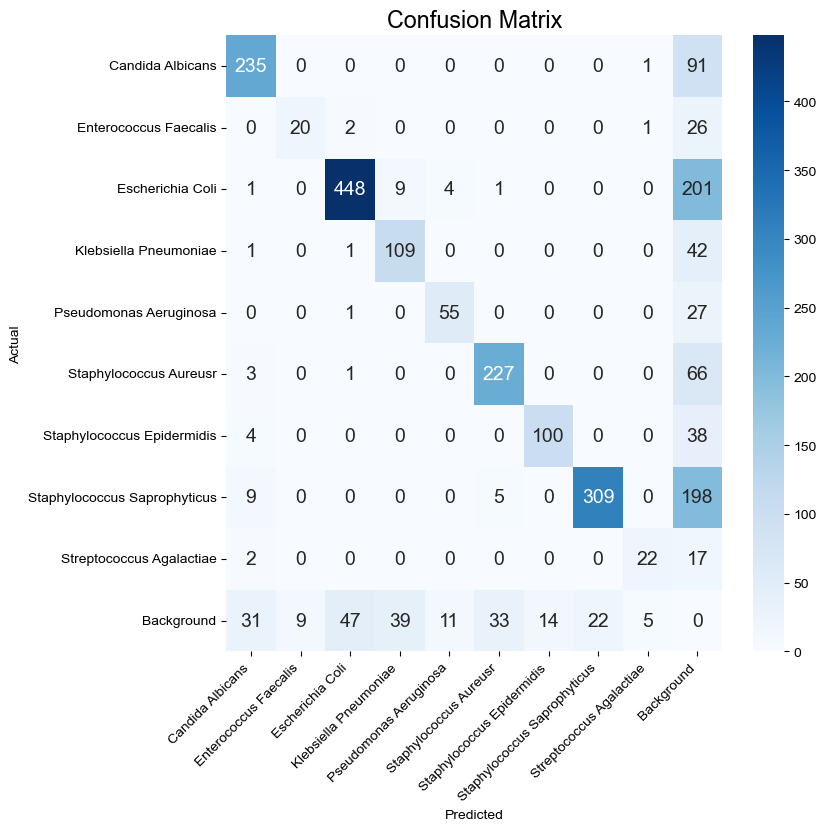

In [ ]:
sn.heatmap(x, annot=x, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names, yticklabels=names,fmt='g')
sn.set(font_scale=1.4) # for label size
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrix.svg",bbox_inches='tight')
plt.show()

In [ ]:
x2 =  x.astype('float') / x.sum(axis=1)[:, np.newaxis]
x2 = np.round(x2, 2)

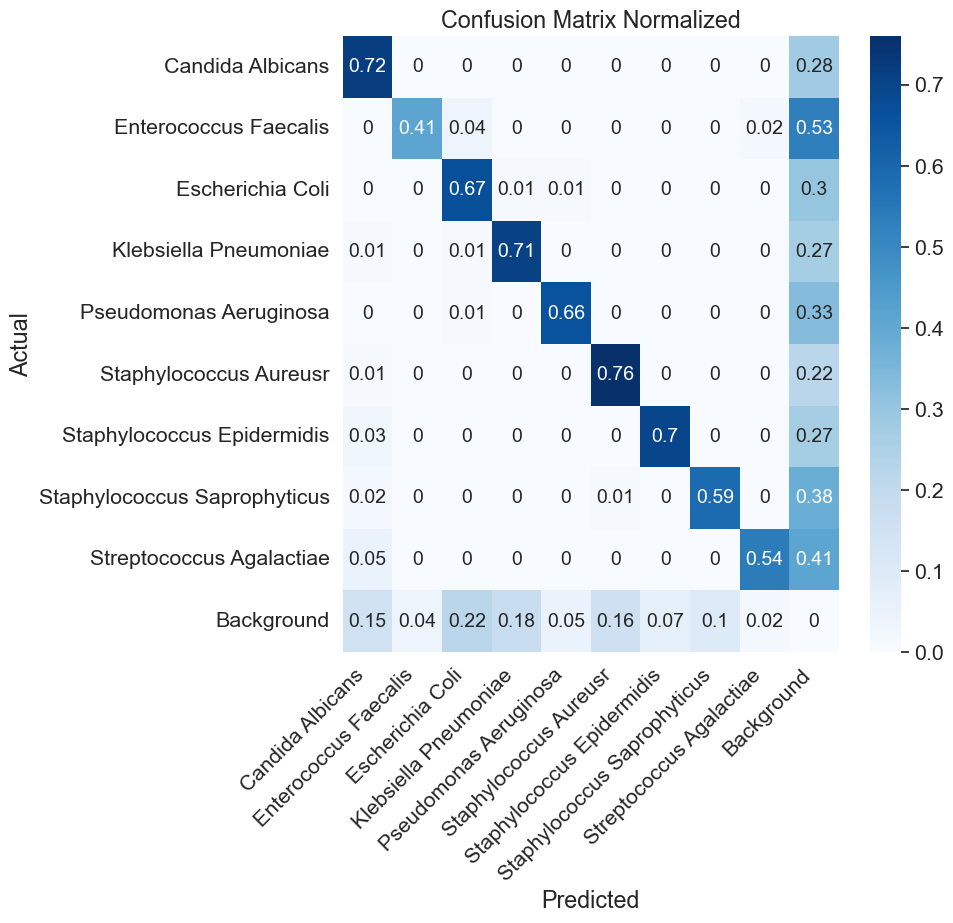

In [ ]:
sn.heatmap(x2, annot=x2, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names, yticklabels=names,fmt='g')
sn.set(font_scale=1.4) # for label size
plt.title('Confusion Matrix Normalized')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrixNormalized.svg",bbox_inches='tight')
plt.show()

Confusion Matrix

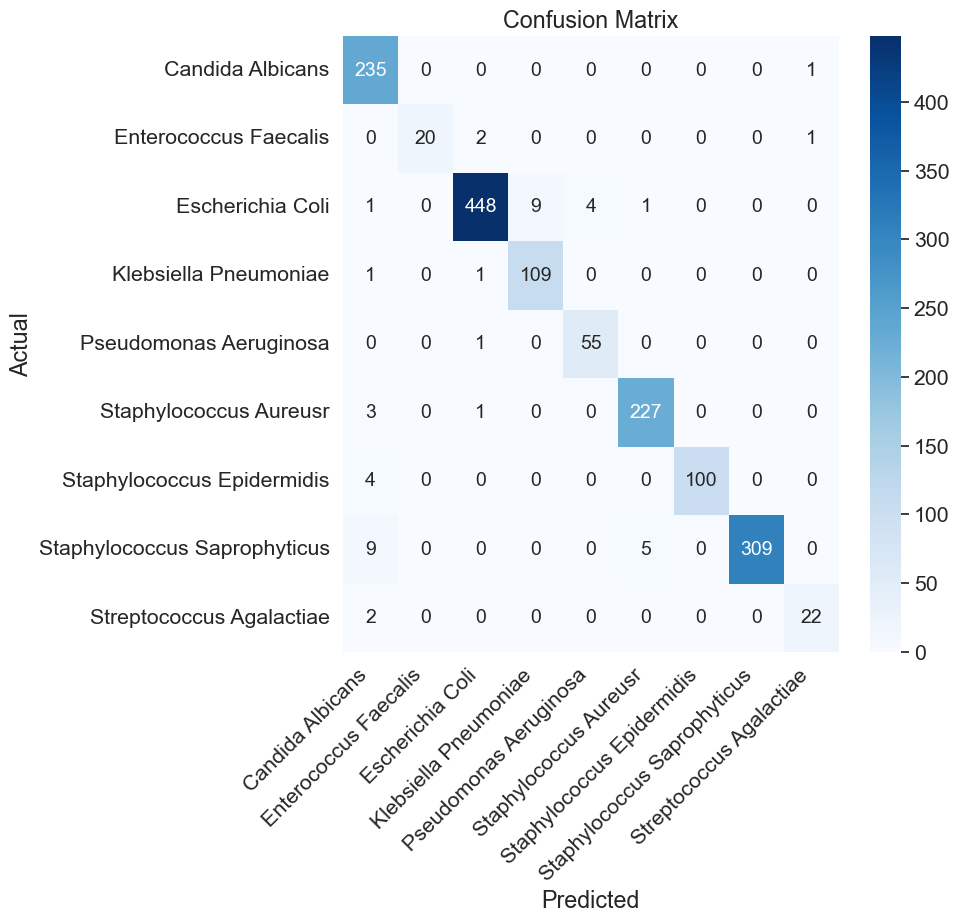

In [ ]:
conf_mat_noback = x[:-1,:-1]
sn.heatmap(conf_mat_noback, annot=conf_mat_noback, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names[:-1], yticklabels=names[:-1],fmt='g')
sn.set(font_scale=1.4) # for label size
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrixNoBack.svg",bbox_inches='tight')
plt.show()

Normalized confusion matrix

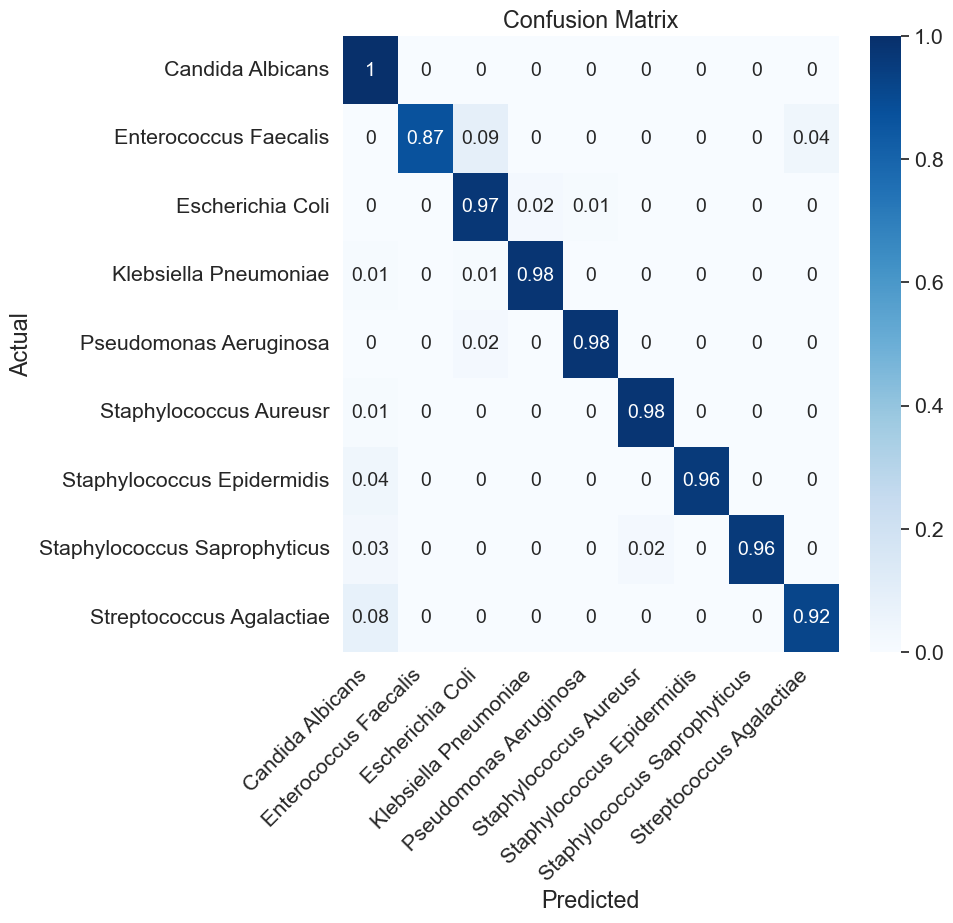

In [ ]:
conf_mat_noback = x[:-1,:-1]
conf_mat_noback_norm =  conf_mat_noback.astype('float') / conf_mat_noback.sum(axis=1)[:, np.newaxis]
conf_mat_noback_norm = np.round(conf_mat_noback_norm, 2)
sn.heatmap(conf_mat_noback_norm, annot=conf_mat_noback_norm, annot_kws={"size": 14},cmap = 'Blues',xticklabels=names[:-1], yticklabels=names[:-1],fmt='g')
sn.set(font_scale=1.4) # for label size
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation = 45, horizontalalignment='right')
plt.gcf().set_size_inches(8, 8)
plt.savefig("ConfusionMatrixNoBackNormalized.svg",bbox_inches='tight')
plt.show()

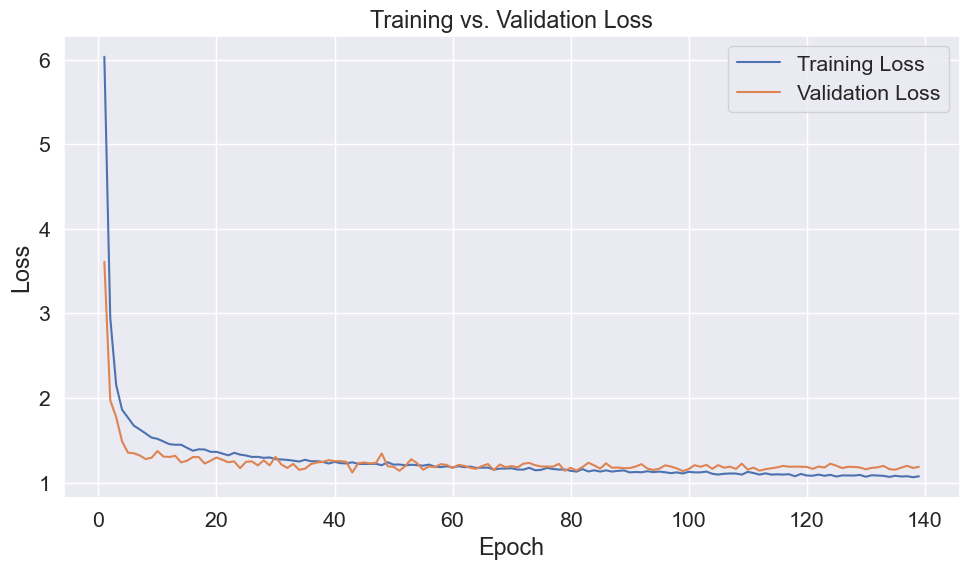

Loss plot saved as 'loss_plot.svg'


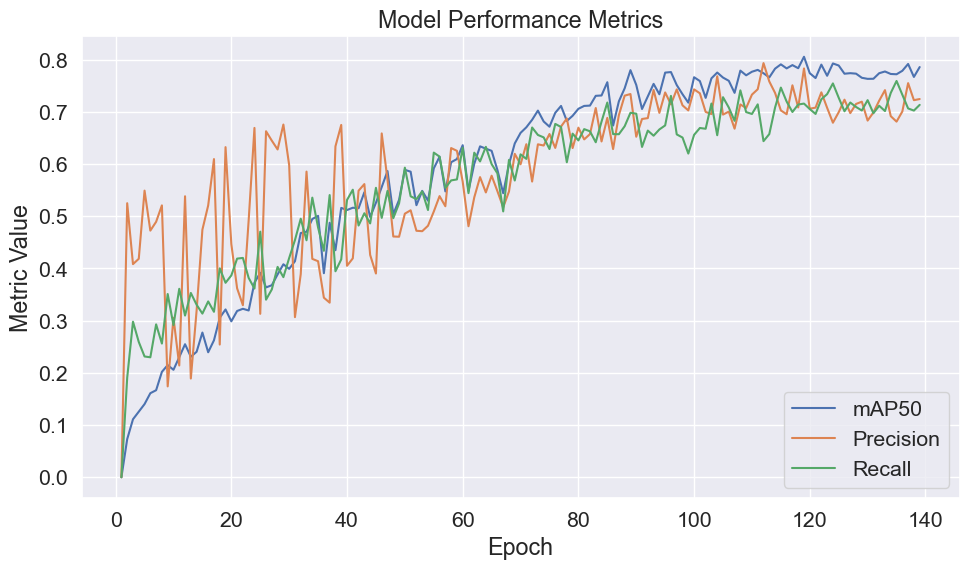

Model metrics plot saved as 'model_metrics_plot.svg'


In [ ]:
# Read the CSV file
data = pd.read_csv('results.csv')
data.columns = data.columns.str.strip()
# Create and save loss plot
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['train/seg_loss'], label='Training Loss')
plt.plot(data['epoch'], data['val/seg_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_plot.svg', format='svg')
plt.show()
plt.close()
print("Loss plot saved as 'loss_plot.svg'")
# Create and save mAP50, precision, and recall plot
plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['metrics/mAP50(M)'], label='mAP50')
plt.plot(data['epoch'], data['metrics/precision(M)'], label='Precision')
plt.plot(data['epoch'], data['metrics/recall(M)'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()
plt.tight_layout()
plt.savefig('model_metrics_plot.svg', format='svg')
plt.show()
plt.close()
print("Model metrics plot saved as 'model_metrics_plot.svg'")

# Add the graph here!

Results
Talk about the improvements
Graphs and talk about the discovery of background noise
How this model wasn’t picking up colonies in every image when though we filtered it with fastSAM
